In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ipywidgets as widgets
import re
import scipy.interpolate
import matplotlib
import sys
import pathlib 


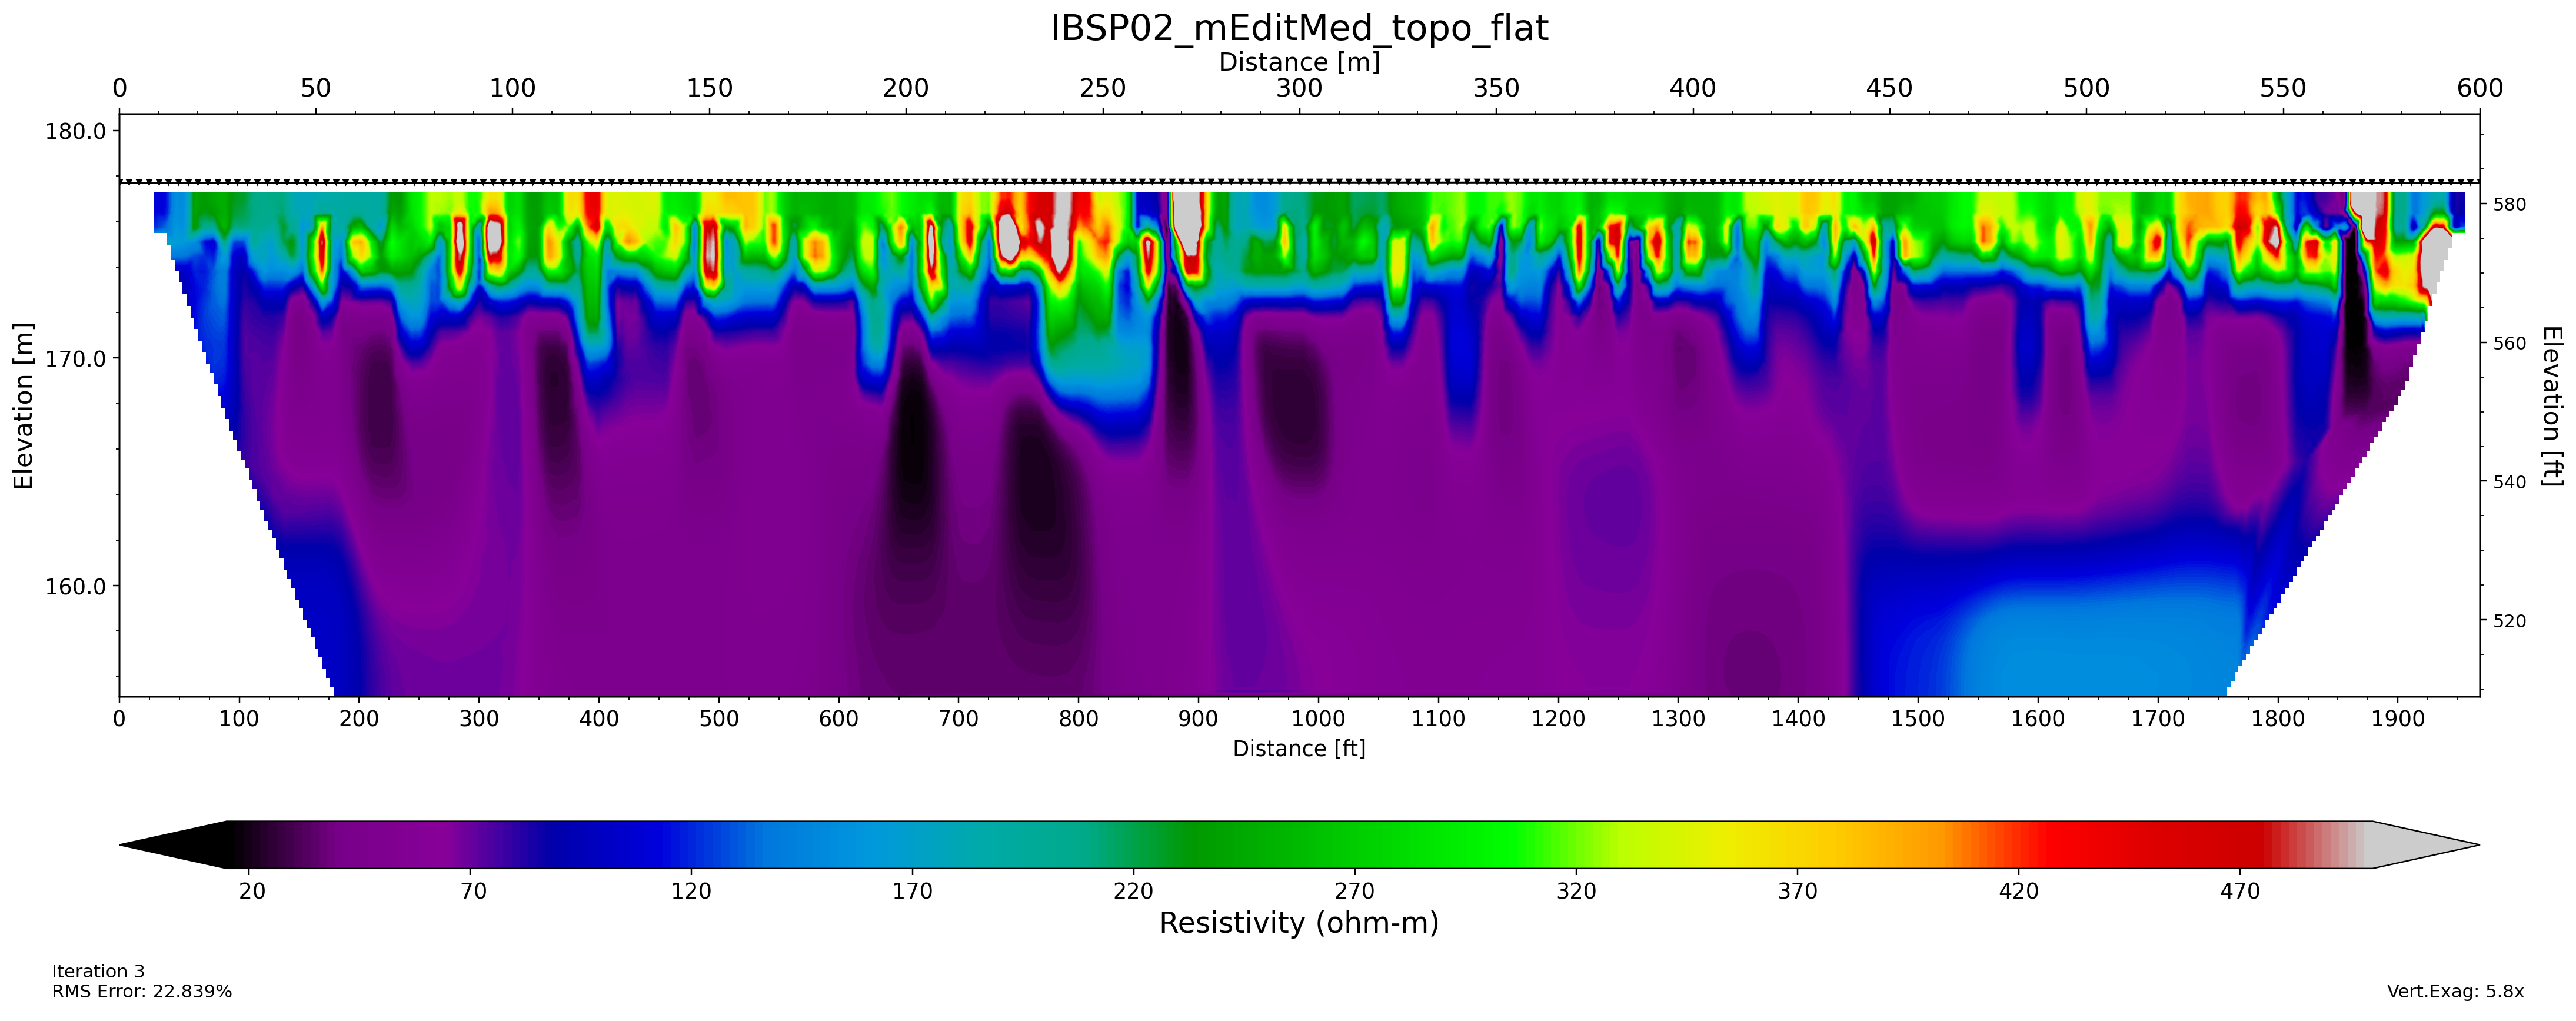

In [5]:
import invplot
invFile = r"\\isgs-sinkhole.ad.uillinois.edu\geophysics\2DResistivityProjects\ChampaignCo\Fisher2022\Inversions\700E_pyEdit_topo.INV"
invFile = r"\\isgs-sinkhole.ad.uillinois.edu\geophysics\Lake Michigan Project\groundsurvey\Inversions\ReEdited_Inversions\IBSP02_mEditMed_topo_flat.INV"
inv_dict = invplot.autoplot(inv_file=invFile, verbose=False, iteration=2, tight_layout=False, cMin=15, cMax=500, cBarOrientation='horizontal',figsize=(20, 8), dpi=220)


In [5]:
list(inv_dict.keys())
inv_dict['resistModelDF']

,ElectrodeNo,Data,zDepth,x,zElev
0,4.0,31.576,0.000000,3.496028,214.765103
1,5.0,27.750,0.000000,4.496018,214.752944
2,6.0,22.588,0.000000,5.495958,214.746706
3,7.0,22.485,0.000000,6.495876,214.743174
4,8.0,22.776,0.000000,7.495799,214.739209
...,...,...,...,...,...
2332,66.0,73.643,29.112379,65.482056,184.395167
2333,67.0,75.158,29.112379,66.481965,184.369704
2334,68.0,76.612,29.112379,67.481381,184.322349
2335,69.0,77.352,29.112379,68.480869,184.279044


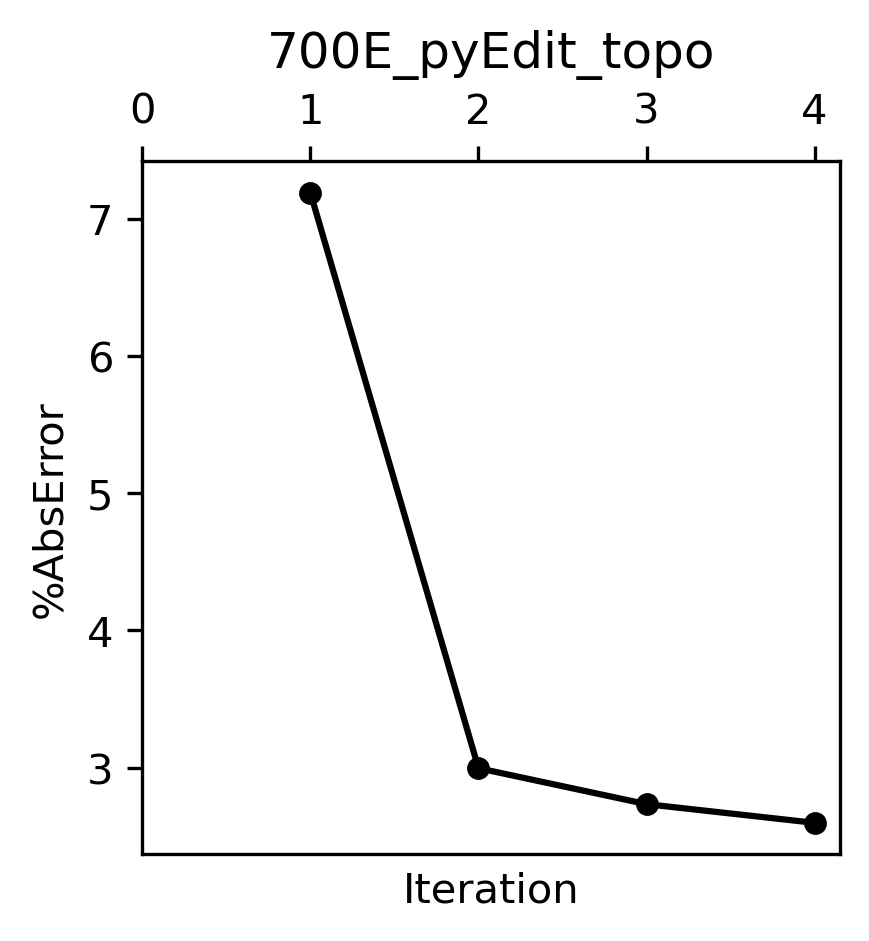

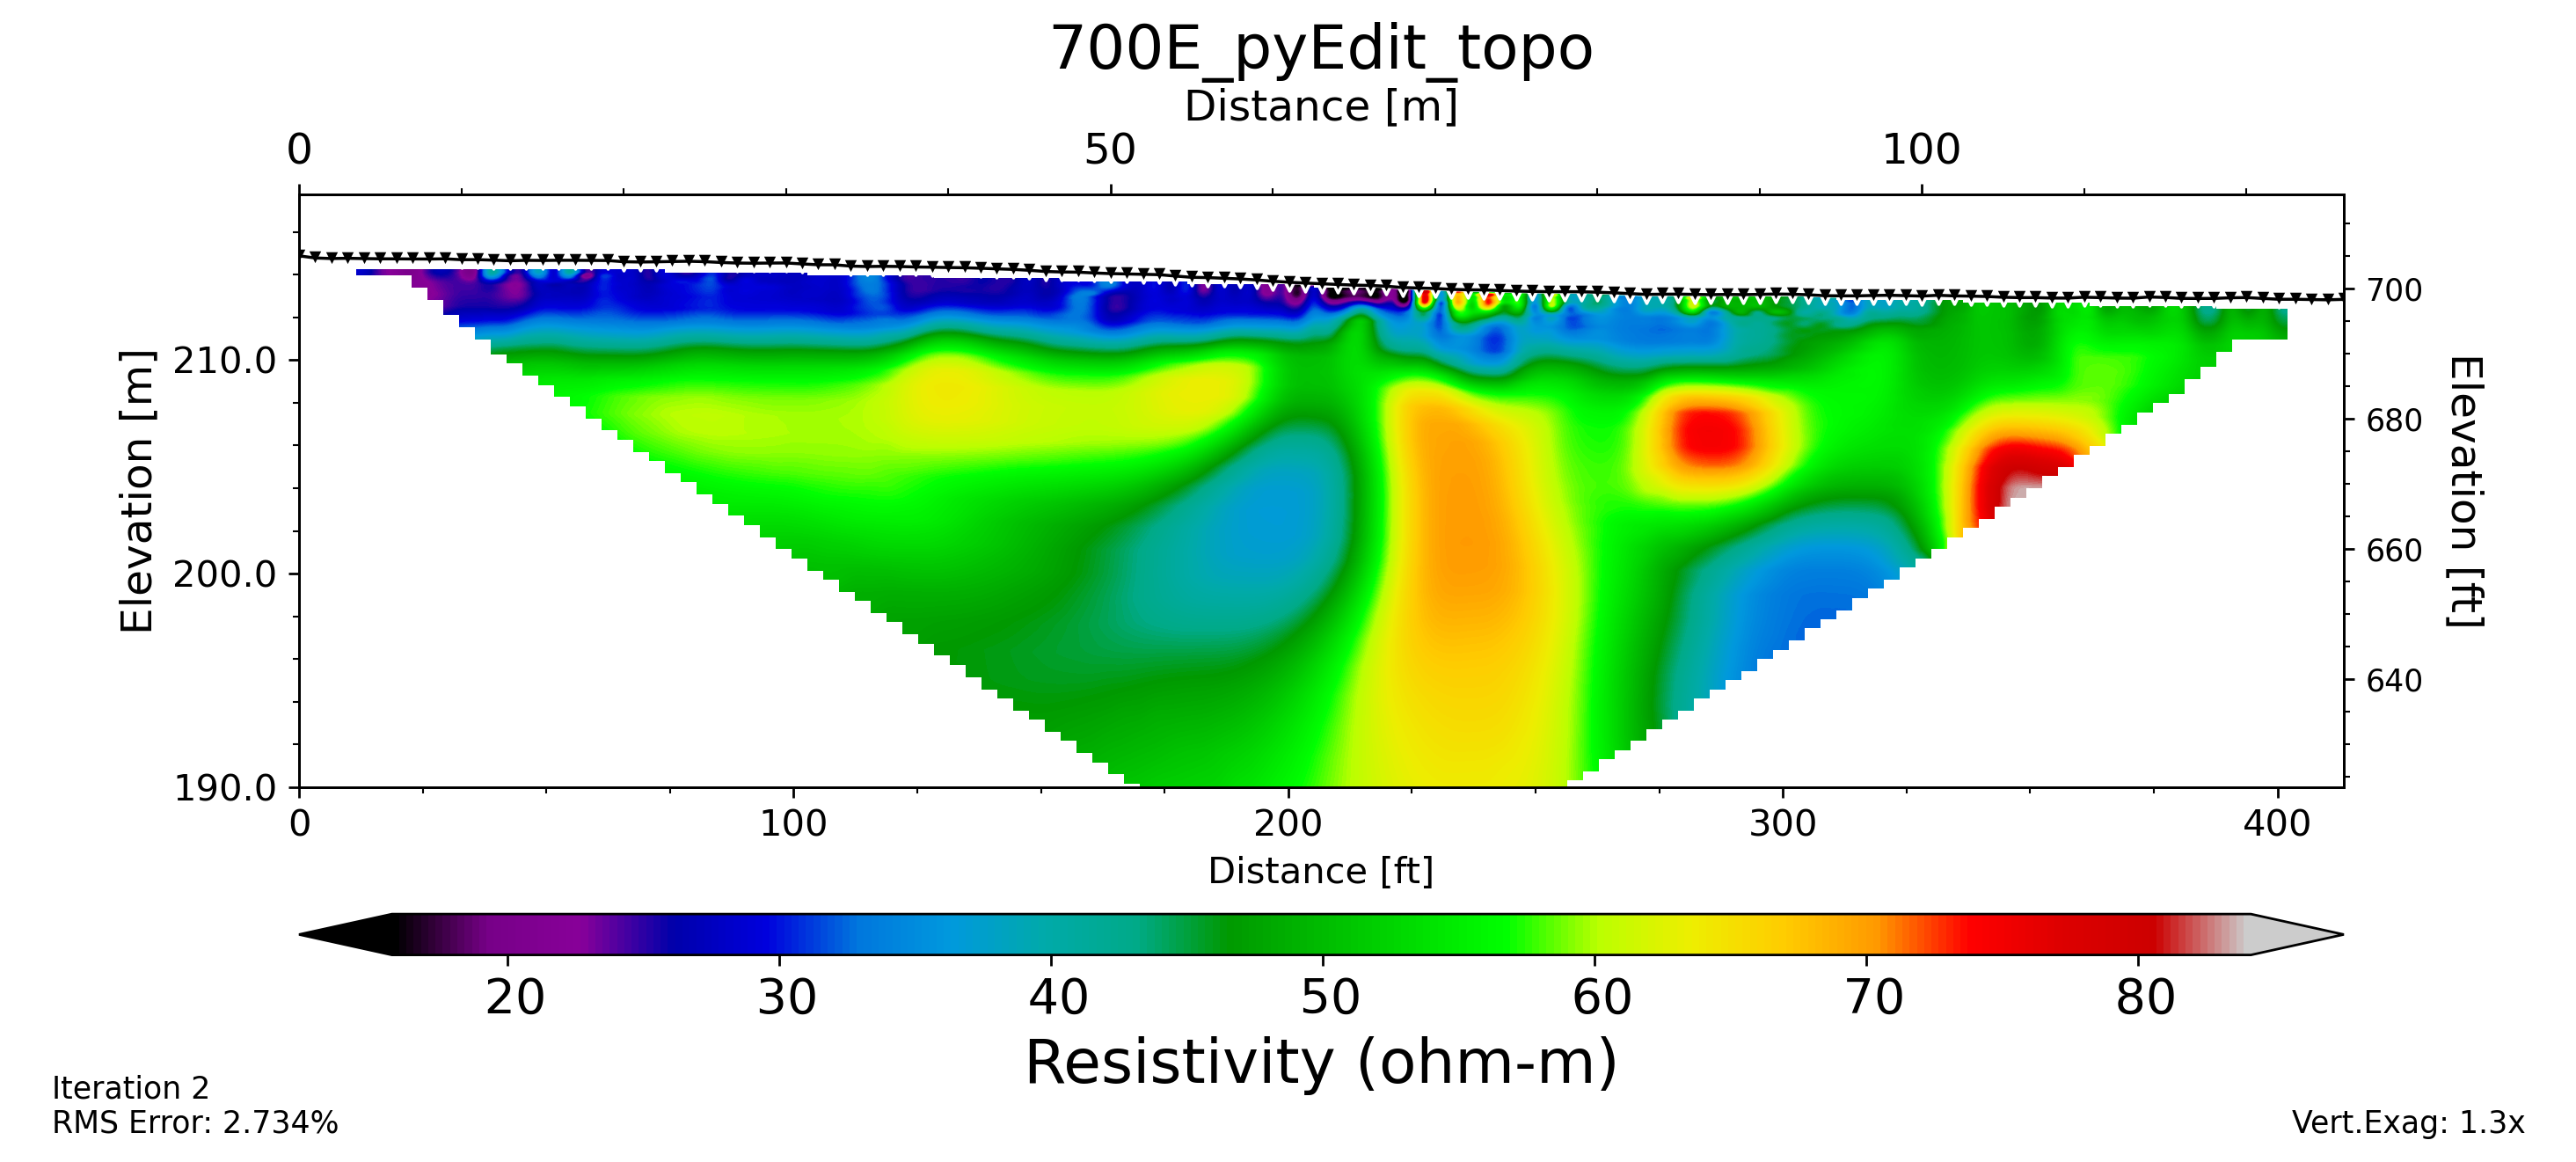

In [4]:
inv_dict = invplot.ingest_inv(invFile, verbose=False)
inv_dict = invplot.read_inv_data(inv_file=invFile, inv_dict=inv_dict)
inv_dict = invplot.read_inv_data_other(inv_file=invFile, inv_dict=inv_dict, iteration_no=2)
inv_dict = invplot.read_error_data(inv_file=invFile, inv_dict=inv_dict)
inv_dict = invplot.get_resistivitiy_model(inv_file=invFile, inv_dict=inv_dict)
fig, ax = invplot.resinv_plot(inv_dict=inv_dict)